In [1]:
import pandas as pd
import numpy as np
import openai
import json
from tqdm import tqdm
import ast
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# import math
# import PyPDF2
import os
import re
import google.generativeai as genai
import signal
import shutil

In [ ]:
genai.configure(api_key= your api key here )
model_2_5_flash = genai.GenerativeModel('gemini-2.5-flash')

In [3]:
question = """Please read the following research papers about the degradation of photovoltaic modules. Your goal is to extract the equation or equations that express this degradation and the values for the associated parameters. Be precise about the units of measurement and formatting of the equation. Return this information in the dictionary format specified below. Only return this dictionary. Do not provide any other information than what is requested. 

The Arrhenius equation describes the relationship between temperature dependence and reaction rates. This can act as the base for mathematical models that describe how temperature dependent degradation processes accelerate. The equations may differ slightly between publications, so be careful to keep track of experimental parameters. 

If the information requested is not available in the paper, put “not reported” in the field for that category.

Provide the information in the following dictionary format. If a publication contains multiple relevant equations, provide a separate dictionary for each.: 
{
Title: [list the title of the paper here]
Authors: [list the name of authors of the paper by first and last name.]
DOI: [if provided, list the DOI of the article here.]
Source Title: [list the paper title here.]
Journal: [List the journal this paper was published in, and if possible, the volume of publication.]
Material: [Specify the photovoltaic material undergoing degradation. Choose from ‘mono-c-Si’, ‘multi-c-Si’, ‘c-Si’,‘a-Si’, ‘CdTe’, ‘CIGS’, ‘thin film’, ‘HIT’, ‘perovskite’, ‘other’, or ‘not reported’; if paper reports it as ‘poly-c-Si’, ‘mc-Si’, ‘multicrystalline silicon’, ‘multicrystalline Si’, or ‘polycrystalline silicon’, it refers to ‘multi-c-Si’. If a paper reports ‘sc-Si’, ‘monocrystalline silicon’, ‘monocrystalline Si’, or ‘single crystal silicon’ refers to ‘mono-c-Si’’]
Degradation: [Specify the type of degradation type studied. This is based on what factors are causing the degradation. Choose from ‘discoloration’, ‘power output’, ‘power conversion efficiency’, ‘CIGS efficiency’, ‘UV transmittance’, ‘hydrolysis’, ‘optical light transmittance’, ‘fill factor’, ‘PID’, ‘moisture ingress’, ‘photoxidation’, ‘LETID’, ‘photodegradation’, or ‘other’. ‘Yellowness index’ refers to ‘discoloration’; the use of “ultraviolet” refers to “UV”; “potential-induced degradation” refers to “PID”; “Light and elevated temperature induced degradation” refers to “LETID”; “LID” or “Light-induced degradation” refers to “photodegradation”]
Stress Factors: [List the key factors that were a part of this degradation happening. This can include light, moisture, and more.]
EquationType: [see the list below the dictionary to select the type. If the equation in the paper is not listed there, put “other”.]
Equation Number: [list the number assigned to the equation within the paper. This number is often found in parenthesis next to the formatted equation. Enter only this number.]
Equation: [Type out the equation formula here. Be exact with the formatting and characters.]
Variables: [List all variables in the equation with their values and units in the format below: 
x_1: {Value: [numerical value]} {Units: [unit of measurement]}
x_2: {Value: [numerical value]} {Units: [unit of measurement]}
y_1: {Value: [numerical value]} {Units: [unit of measurement]}
T_a: {Value: [numerical value]} {Units: [unit of measurement]}
“T_f”: {Value: [numerical value]} {Units: [unit of measurement]}
}
Note that this is an example with arbitrary variable names and an arbitrary number of variables. In the dictionary, reflect the exact variables that are found in the equation.

The known equation types to choose from are listed below. The associated equation and equation type are in square brackets.: 
["EquationType": "Arrhenius",
"Equation": "R_D=R_0*e^(-E_a/(R*T_K ))"]

["EquationType": "Vant_Hoff_TOW_Schwarzchild",
"Equation": "R_D=R_0*G^x (1/(b+m*TOW))(T_f^(T/10) )"]

["EquationType": "Arrhenius_BET",
"Equation": "R_D=R_0*e^(-E_a/(R*T_K )) (RH/(1-RH+E))"]

["EquationType": "Arrhenius_RH_Irradiance",
"Equation": "R_D=R_0*RH^n*G_340^P*e^(-E_a/K_(b*T_K ) )"]

["EquationType": "Arrhenius_tfail_RH",
"Equation": "t_fail=e^(E_a/(ln(A)*R*T_K))/(RH^2)"]

[ "EquationType": "Perovskite_1",
"Equation": "R_D=R_(0,WPO)*e^(-E_(a,WPO)/(k_b*T_K ))*((P_(O_2 )*P_(H_2 O)*G_550^.07 ))/(1+K_2W*P_(O_2 ) (1+K_3W*G_550^0.7 ))^2 +R_(0,DPO)*e^(-E_(a,DPO)/(k_b*T_K ))*((P_(O_2 )*G_550^0.7 ))/(1+K_2D*P_(O_2 ) (1+K_3D*G_550^0.7 ))^2 +R_(0, hum)*e^(-(E_a^hum)/(k_b*T_K ))*P_(H_2O)*G_550^0.7+R_(0,therm)*e^(-(E_a^therm)/(k_b*T_K ))"]

["EquationType": "FF_Arrhenius",
"Equation": "FF_t=FF_0*(1-A_i/A_o*(1-e^(-e^((B_1-B_2/(k_b*T_K )-B_3*RH)) ) ))"]

["EquationType": "Arrhenius_Connector",
"Equation": "R_D=R_(0, thermal)*e^(-E_(a,thermal)/(k_b*T_K ))+R_(0, Hydrolysis)*RH^m*e^(-E_(a,hydrolysis)/(k_b*T_K ))+R_(0, PhotoDegr)*G^n*e^(-E_(a,PhotoDegr)/(k_b*T_K ))"]

[ "EquationType": "Arrhenius_Coffin_Manson_Peck",
"Equation": "R_D=B_0*e^(-B_1/(K_b*T_K ))*(T_Delta)^(B_2 )*(UV_Daily)^(B_3 )*(RH_Daily)?^(B_4 )"]

["EquationType": "Arrhenius_G_DeltaT",
"Equation": "R_D=R_0*G*e^(-E_a/(R*T_K ))*?T_K"]

["EquationType": "Activation Spectrum",
"Equation": "Activation Spectrum=(E_L)*(R_0*e^(-B_g*L))"]

["EquationType": "Arrhenius_Schwarzchild_340",

["Equation": "R_D=R_0*?G_340?^P*e^(E_a/(R*T_K ))"]

Here is one example of what the dictionary could be.
{
Title: "Error Analyses and Associated Risk for Accelerated Weathering Results/2009 Presentation",
Authors: "Richard M. Fischer, Warren D. Ketola",
DOI: “not reported”
Reference: "R. M. Fischer and W. D. Ketola, "Error Analyses and Associated Risk for Accelerated Weathering Results," Third International Service Life Symposium, Sedona, AZ February 2004, 2004.",
Material: “Paints and Coatings”,
Degradation: "Gloss, color shift, cracking, gloss loss, fluorescence loss, retroreflectance loss, adhesive transfer (clean removal), shrinkage, yellowing",
Stress Factors: “not reported”
EquationType: "Vant_Hoff_TOW_Schwarzchild",
Equation Number: “2”
Equation: "R_D=R_0*G^x (1/(b+m*TOW))(T_f^(T/10) )",
Variables:
R_D: {},
R_0: {            Units: "%/h"        },
x: {            Value: 0.64,            STDEV: 0.64        },
b: {            Value: 1.07,            STDEV: 0.11        },
m: {            Value: -0.000028,            STDEV: 0.0000488        },
T_f: {            Value: 1.41,            STDEV: 0.23        },    },
}


Here is a second example. 
{
Title: "Life Prediction for CIGS Solar Modules",
Authors: "D.J. Coyle, H.A. Blaydes, R.S. Northey, J.E. Pickett, K.R. Nagarkar, R.A. Zhao, and J.O. Gardner",
DOI: "10.1002/.pip1172",

Reference: "Coyle, D. J., et al. (2011). "Life prediction for CIGS solar modules part 2: degradation kinetics, accelerated testing, and encapsulant effects." Progress in Photovoltaics: Research and Applications.",
Stress Factors: "Temperature, humidity, Moisture ingress",
Material: "CIGS, thin film",
Degradation: "CIGS_Efficiency, ITO_ECA0",
EquationType: "Arrhenius_BET4",
Equation Number: “4”
Equation: "R_D=R_0*e^(-E_a/(R*T_K )) (RH/(1-RH+E))",
Variables:
R_D: {            Units: "%/h"        },
R_0: {            Value: 845000000            Units: "%/h"        },
E_a: {            Value: 33.472            Units: "kJ/mol"        },
E: {            Value: 0.04        },    },
}

"""


In [4]:
question2 = """
You are researching the degradation of photovoltaic modules. To understand this mathematically, you are reading research papers and extracting the equations that describe the degradation rate. Once you’ve found the appropriate equations, you want to organize them for understanding and analysis. 

When reading these papers, look at the context in which the equation is listed. Our concern is the rate of degradation of the solar modules. Do not include equations that are part of derivations. 

To do this, fill out the following dictionary format with the required information. Reflect the information from the paper exactly as it appears.
{
Title: [list the title of the paper here]
Authors: [list the name of authors of the paper by first and last name.]
Material: [Specify the photovoltaic material undergoing degradation. Choose from ‘mono-c-Si’, ‘multi-c-Si’, ‘c-Si’,‘a-Si’, ‘CdTe’, ‘CIGS’, ‘thin film’, ‘HIT’, ‘perovskite’, ‘other’, or ‘not reported’; if paper reports it as ‘poly-c-Si’, ‘mc-Si’, ‘multicrystalline silicon’, ‘multicrystalline Si’, or ‘polycrystalline silicon’, it refers to ‘multi-c-Si’. If a paper reports ‘sc-Si’, ‘monocrystalline silicon’, ‘monocrystalline Si’, or ‘single crystal silicon’ refers to ‘mono-c-Si’’]
Degradation: [Specify the type of degradation type studied. This is based on what factors are causing the degradation. Choose from ‘discoloration’, ‘power output’, ‘power conversion efficiency’, ‘CIGS efficiency’, ‘UV transmittance’, ‘hydrolysis’, ‘optical light transmittance’, ‘fill factor’, ‘PID’, ‘moisture ingress’, ‘photoxidation’, ‘LETID’, ‘photodegradation’, or ‘other’. ‘Yellowness index’ refers to ‘discoloration’; the use of “ultraviolet” refers to “UV”; “potential-induced degradation” refers to “PID”; “Light and elevated temperature induced degradation” refers to “LETID”; “LID” or “Light-induced degradation” refers to “photodegradation”]
Stress Factors: [List the key factors that were a part of this degradation happening. This can include light, moisture, and more.]
EquationType: [see the list below the dictionary to select the type. If the equation in the paper is not listed there, put “other”.]
Equation Number: [list the number assigned to the equation within the paper. This number is often found in parenthesis next to the formatted equation. Enter only this number.]
Equation: [Type out the equation formula here. Be exact with the formatting and characters.]
Variables: [List all variables in the equation with their values and units in the format below: 
x_1: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
x_2: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
y_1: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
T_a: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
“T_f”: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
}
Note that this is an example with arbitrary variable names and an arbitrary number of variables. In the dictionary, reflect the exact variables that are found in the equation.

The known equation types to choose from are listed below. The associated equation and equation type are in square brackets.: 
["EquationType": "Arrhenius",
"Equation": "R_D=R_0*e^(-E_a/(R*T_K ))"]

["EquationType": "Vant_Hoff_TOW_Schwarzchild",
"Equation": "R_D=R_0*G^x (1/(b+m*TOW))(T_f^(T/10) )"]

["EquationType": "Arrhenius_BET",
"Equation": "R_D=R_0*e^(-E_a/(R*T_K )) (RH/(1-RH+E))"]

["EquationType": "Arrhenius_RH_Irradiance",
"Equation": "R_D=R_0*RH^n*G_340^P*e^(-E_a/K_(b*T_K ) )"]

["EquationType": "Arrhenius_tfail_RH",
"Equation": "t_fail=e^(E_a/(ln(A)*R*T_K))/(RH^2)"]

[ "EquationType": "Perovskite_1",
"Equation": "R_D=R_(0,WPO)*e^(-E_(a,WPO)/(k_b*T_K ))*((P_(O_2 )*P_(H_2 O)*G_550^.07 ))/(1+K_2W*P_(O_2 ) (1+K_3W*G_550^0.7 ))^2 +R_(0,DPO)*e^(-E_(a,DPO)/(k_b*T_K ))*((P_(O_2 )*G_550^0.7 ))/(1+K_2D*P_(O_2 ) (1+K_3D*G_550^0.7 ))^2 +R_(0, hum)*e^(-(E_a^hum)/(k_b*T_K ))*P_(H_2O)*G_550^0.7+R_(0,therm)*e^(-(E_a^therm)/(k_b*T_K ))"]

["EquationType": "FF_Arrhenius",
"Equation": "FF_t=FF_0*(1-A_i/A_o*(1-e^(-e^((B_1-B_2/(k_b*T_K )-B_3*RH)) ) ))"]

["EquationType": "Arrhenius_Connector",
"Equation": "R_D=R_(0, thermal)*e^(-E_(a,thermal)/(k_b*T_K ))+R_(0, Hydrolysis)*RH^m*e^(-E_(a,hydrolysis)/(k_b*T_K ))+R_(0, PhotoDegr)*G^n*e^(-E_(a,PhotoDegr)/(k_b*T_K ))"]

[ "EquationType": "Arrhenius_Coffin_Manson_Peck",
"Equation": "R_D=B_0*e^(-B_1/(K_b*T_K ))*(T_Delta)^(B_2 )*(UV_Daily)^(B_3 )*(RH_Daily)?^(B_4 )"]

["EquationType": "Arrhenius_G_DeltaT",
"Equation": "R_D=R_0*G*e^(-E_a/(R*T_K ))*?T_K"]

["EquationType": "Activation Spectrum",
"Equation": "Activation Spectrum=(E_L)*(R_0*e^(-B_g*L))"]

["EquationType": "Arrhenius_Schwarzchild_340",
["Equation": "R_D=R_0*?G_340?^P*e^(E_a/(R*T_K ))"]



Once again, remember to reflect the same structure as outlined in this set of samples. If an equation is mathematically equivalent to one of these, follow the format noted in this prompt. 
"""

In [14]:
question3 = """
You are researching the degradation of photovoltaic modules. To understand this mathematically, you are reading research papers and extracting the equations that describe the degradation rate. Once you’ve found the appropriate equations, you want to organize them for understanding and analysis. 

When reading these papers, look at the context in which the equation is listed. Our concern is the rate of degradation of the solar modules. Do not include equations that are part of derivations. 

For exponents, use ^ and put any exponentiated part of the equation within parenthesis (). For subscripts, use _ and put any subscripted parts within parentheses ().

To do this, fill out the following dictionary format with the required information. Reflect the information from the paper exactly as it appears.
{
Title: [list the title of the paper here]
Authors: [list the name of authors of the paper by first and last name.]
Material: [Specify the photovoltaic material undergoing degradation. Choose from ‘mono-c-Si’, ‘multi-c-Si’, ‘c-Si’,‘a-Si’, ‘CdTe’, ‘CIGS’, ‘thin film’, ‘HIT’, ‘perovskite’, ‘other’, or ‘not reported’; if paper reports it as ‘poly-c-Si’, ‘mc-Si’, ‘multicrystalline silicon’, ‘multicrystalline Si’, or ‘polycrystalline silicon’, it refers to ‘multi-c-Si’. If a paper reports ‘sc-Si’, ‘monocrystalline silicon’, ‘monocrystalline Si’, or ‘single crystal silicon’ refers to ‘mono-c-Si’’]
Degradation: [Specify the type of degradation type studied. This is based on what factors are causing the degradation. Choose from ‘discoloration’, ‘power output’, ‘power conversion efficiency’, ‘CIGS efficiency’, ‘UV transmittance’, ‘hydrolysis’, ‘optical light transmittance’, ‘fill factor’, ‘PID’, ‘moisture ingress’, ‘photoxidation’, ‘LETID’, ‘photodegradation’, or ‘other’. ‘Yellowness index’ refers to ‘discoloration’; the use of “ultraviolet” refers to “UV”; “potential-induced degradation” refers to “PID”; “Light and elevated temperature induced degradation” refers to “LETID”; “LID” or “Light-induced degradation” refers to “photodegradation”]
Stress Factors: [List the key factors that were a part of this degradation happening. This can include light, moisture, and more.]
EquationType: [Explain what this equation describes. This may be an exponential fit of a degradation curve, a form of Arrhenius equation, a rate of exchange of recombination, or other expression related to degradation. Remember to use the context of the paper, and be accurate to the context.]
Equation Number: [list the number assigned to the equation within the paper. This number is often found in parenthesis next to the formatted equation. Enter only this number.]
Equation: [Type out the equation formula here. Be exact with the formatting and characters.]
Variables: [List all variables in the equation with their values and units in the format below: 
x_1: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
x_2: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
y_1: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
T_a: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
“T_f”: {Description: [describe what this variable is]} {Value: [numerical value]} {Units: [unit of measurement]}
}
Note that this is an example with arbitrary variable names and an arbitrary number of variables. In the dictionary, reflect the exact variables that are found in the equation.

IMPORTANT: If values for variables are available in the paper, provide them. If they are in a table, print a copy of that table at the end of the dictionary. If there are no values available, indicate so. Be sure to be accurate to the information in the paper. Do not state "variea per case" and list examples - just print the copy of the table of values. If you cannot print this table, just list the table name. 
"""

In [38]:
question4 = """
You are researching the degradation of photovoltaic modules. Your goal is to extract **equations that describe the degradation rate** and organize them along with their **variables, values, and units** for further analysis. These values may appear in the text, figure captions, or tables. If variable values are available, include them exactly as reported. If a table lists them, reproduce the table or include the table name.

When analyzing papers, follow these instructions:

1. Focus only on equations related to the **degradation rate** of the solar modules.
2. Do **not** include equations used purely in derivations or background physics.
3. Maintain formatting: 
   - For **exponents**, use `^` and place the exponent base in parentheses, e.g., `(x)^2`
   - For **subscripts**, use `_` and place the subscript base in parentheses, e.g., `R_(sh)`
4. Report information in the following dictionary format:

{
Title: [List the full title of the paper]  
Authors: [List all author names as "First Last"]  
Material: [Specify the photovoltaic material undergoing degradation. Choose from:
  ‘mono-c-Si’, ‘multi-c-Si’, ‘c-Si’, ‘a-Si’, ‘CdTe’, ‘CIGS’, ‘thin film’, ‘HIT’, ‘perovskite’, ‘other’, or ‘not reported’.  
  Normalize synonyms:  
  - “poly-c-Si”, “mc-Si”, “multicrystalline silicon” → “multi-c-Si”  
  - “sc-Si”, “monocrystalline silicon”, “single crystal silicon” → “mono-c-Si”]  
Degradation: [Specify the type of degradation studied. Choose from:
  ‘discoloration’, ‘power output’, ‘power conversion efficiency’, ‘CIGS efficiency’, ‘UV transmittance’,  
  ‘hydrolysis’, ‘optical light transmittance’, ‘fill factor’, ‘PID’, ‘moisture ingress’,  
  ‘photoxidation’, ‘LETID’, ‘photodegradation’, or ‘other’.  
  Normalize synonyms:  
  - “yellowness index” → “discoloration”  
  - “potential-induced degradation” → “PID”  
  - “Light and elevated temperature induced degradation” → “LETID”  
  - “Light-induced degradation” or “LID” → “photodegradation”]  
Stress Factors: [List the key external factors contributing to degradation: e.g., UV light, moisture, temperature, etc.]  
EquationType: [Briefly describe the purpose of the equation, e.g., exponential fit of degradation curve, Arrhenius equation, recombination rate, etc.]  
Equation Number: [List the equation number as labeled in the paper (e.g., (3))]  
Equation: [Write out the equation using the formatting rules described above]  
Variables: {
  var_1: {
    Description: [Describe what this variable represents],
    Value: [Numerical value or "not reported"],
    Units: [Unit of measurement or "not reported"]
  },
  var_2: {
    Description: [Describe what this variable represents],
    Value: [Numerical value or "not reported"],
    Units: [Unit of measurement or "not reported"]
  },
  ...
}
}

If any variable values are found in a **table**, reproduce the table at the end of the dictionary. If the table cannot be copied, just list the **table name or number**.
Values MAY be in the text, figure captions, or tables. Read these before concluding that values are not available. If values are not available, indicate so with "not reported".

IMPORTANT:
- Accurately reflect what is written in the paper.
- Do **not** estimate or average values that are not directly stated.
- After completing the dictionary, review the full paper again to check if any variable values were missed, especially from tables or figure captions.
"""


In [39]:
pdf_files = [os.path.splitext(f)[0] for f in os.listdir("Equation_extraction") if f.endswith('.pdf')]
pdf_files = sorted(pdf_files)
failed_folder = "equation_numb_extraction_failed"
os.makedirs(failed_folder, exist_ok=True)
os.makedirs("json", exist_ok=True)  # <-- add this line
 #create json output folder

In [40]:
def handler(signum, frame):
    raise TimeoutError

pdf_folder = "Equation_extraction"
failed_folder = "equation_numb_extraction_failed"
os.makedirs(failed_folder, exist_ok=True)
min_size_bytes = 1024  # 1 KB minimum size to consider the file valid

# Iterate over selected PDF files
for paper_title in tqdm(pdf_files, desc="Processing papers"):

    pdf_path = os.path.join(pdf_folder, f"{paper_title}.pdf")

    # Skip empty/damaged files
    if not os.path.exists(pdf_path):
        print(f"{paper_title} skipped: file not found.")
        continue

    if os.path.getsize(pdf_path) < min_size_bytes:
        print(f"{paper_title} skipped: file too small or empty.")
        shutil.move(pdf_path, os.path.join(failed_folder, f"{paper_title}.pdf"))
        continue

    try:
        # Optional: try opening PDF to make sure it has pages (using PyMuPDF / fitz)
        import fitz
        doc = fitz.open(pdf_path)
        if doc.page_count == 0:
            raise ValueError("PDF has no pages.")
        doc.close()

        # Set a timeout of 15 seconds for upload
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(15)

        myfile = genai.upload_file(pdf_path)

        # Disable alarm after successful upload
        signal.alarm(0)

        model = genai.GenerativeModel("gemini-2.5-flash")
        result = model.generate_content(
            [question4, "\n\n", myfile],
            generation_config={"temperature": 0} # Set temperature to 0 for deterministic output
        )

        res_text = result.text

        match = re.search(r'```json\n([\s\S]+?)\n```', res_text)
        if match:
            json_data = json.loads(match.group(1))
            output_file = f"json/gemini_{paper_title}.json"
            with open(output_file, "w") as file:
                json.dump(json_data, file, indent=4)

    except TimeoutError:
        print(f'{paper_title} failed due to upload timeout')
        shutil.move(pdf_path, os.path.join(failed_folder, f"{paper_title}.pdf"))
        continue

    except Exception as e:
        print(f'{paper_title} failed due to: {e}')
        shutil.move(pdf_path, os.path.join(failed_folder, f"{paper_title}.pdf"))
        continue

Processing papers:  70%|███████   | 7/10 [05:51<02:40, 53.64s/it]

Die Angewandte Makromolekulare Chemie - March 1994 - Cruz‐Pinto - The kinetics and mechanism of polyethylene failed due to: Extra data: line 42 column 2 (char 1362)


Processing papers: 100%|██████████| 10/10 [07:26<00:00, 44.64s/it]


In [41]:
json_data

[{'Title': 'Water-Accelerated Photooxidation of CH3NH3PbI3 Perovskite',
  'Authors': 'Timothy D. Siegler, Wiley A. Dunlap-Shohl, Yuhuan Meng, Yuhang Yang, Wylie F. Kau, Preetham P. Sunkari, Chang En Tsai, Zachary J. Armstrong, Yu-Chia Chen, David A. C. Beck, Marina Meilă, Hugh W. Hillhouse',
  'Material': 'perovskite',
  'Degradation': 'material decomposition rate',
  'Stress Factors': 'O2, H2O, temperature, illumination (photon flux)',
  'EquationType': 'Definition of MAPbI3 decomposition rate from optical absorbance',
  'Equation Number': '(1)',
  'Equation': 'r_(MAPbI3) = (1/W) * (dN/dt) = (rho * log_10(dA)) / (a * M * dt)',
  'Variables': {'r_(MAPbI3)': {'Description': 'Rate of MAPbI3 decomposition',
    'Value': 'not reported',
    'Units': 'mol·m^(-2)·s^(-1)'},
   'W': {'Description': 'Area of the beam',
    'Value': 'not reported',
    'Units': 'm^2'},
   'N': {'Description': 'Number of moles of MAPbI3 in the region sampled by the beam',
    'Value': 'not reported',
    'Units':

print equations with special characters

In [ ]:
import json

def print_unicode_json(file_path):
    # Load JSON file
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Pretty-print entire JSON with readable Unicode
    print("Full JSON content:\n")
    print(json.dumps(data, indent=2, ensure_ascii=False))

    # If data is a list of records, iterate through them
    if isinstance(data, list):
        for i, item in enumerate(data):
            equation_number = item.get("Equation Number", "Not found")
            print("Number:", equation_number)
            equation = item.get("Equation", "Not found")
            print("Equation:", equation)



    else:
        print("Unsupported JSON format.")

# read the appropriate JSON file
file_path = '/Users/rayna/Downloads/HackingMat/json/gemini_1-s2.0-S0141391013000918-main.json'
print_unicode_json(file_path)


Full JSON content:

[
  {
    "Title": "Hydrolysis kinetics of condensation polymers under humidity aging conditions",
    "Authors": "James E. Pickett, Dennis J. Coyle",
    "Material": "other (Polycarbonate (PC), poly(ethylene terephthalate) (PET), resorcinol polyarylate (RPA))",
    "Degradation": "hydrolysis leading to embrittlement/loss of ductility",
    "Stress Factors": "Temperature, Relative Humidity",
    "EquationType": "General rate equation for hydrolysis",
    "Equation Number": "(2)",
    "Equation": "d(P)/dt = k(P)(H2O)",
    "Variables": {
      "d(P)/dt": {
        "Description": "Rate of change of polymer concentration",
        "Value": "not reported",
        "Units": "not reported"
      },
      "k": {
        "Description": "Rate constant",
        "Value": "not reported",
        "Units": "not reported"
      },
      "(P)": {
        "Description": "Concentration of polymer repeat units",
        "Value": "considered constant",
        "Units": "not reported"


# graph generation
relevant for questions 1 & 2


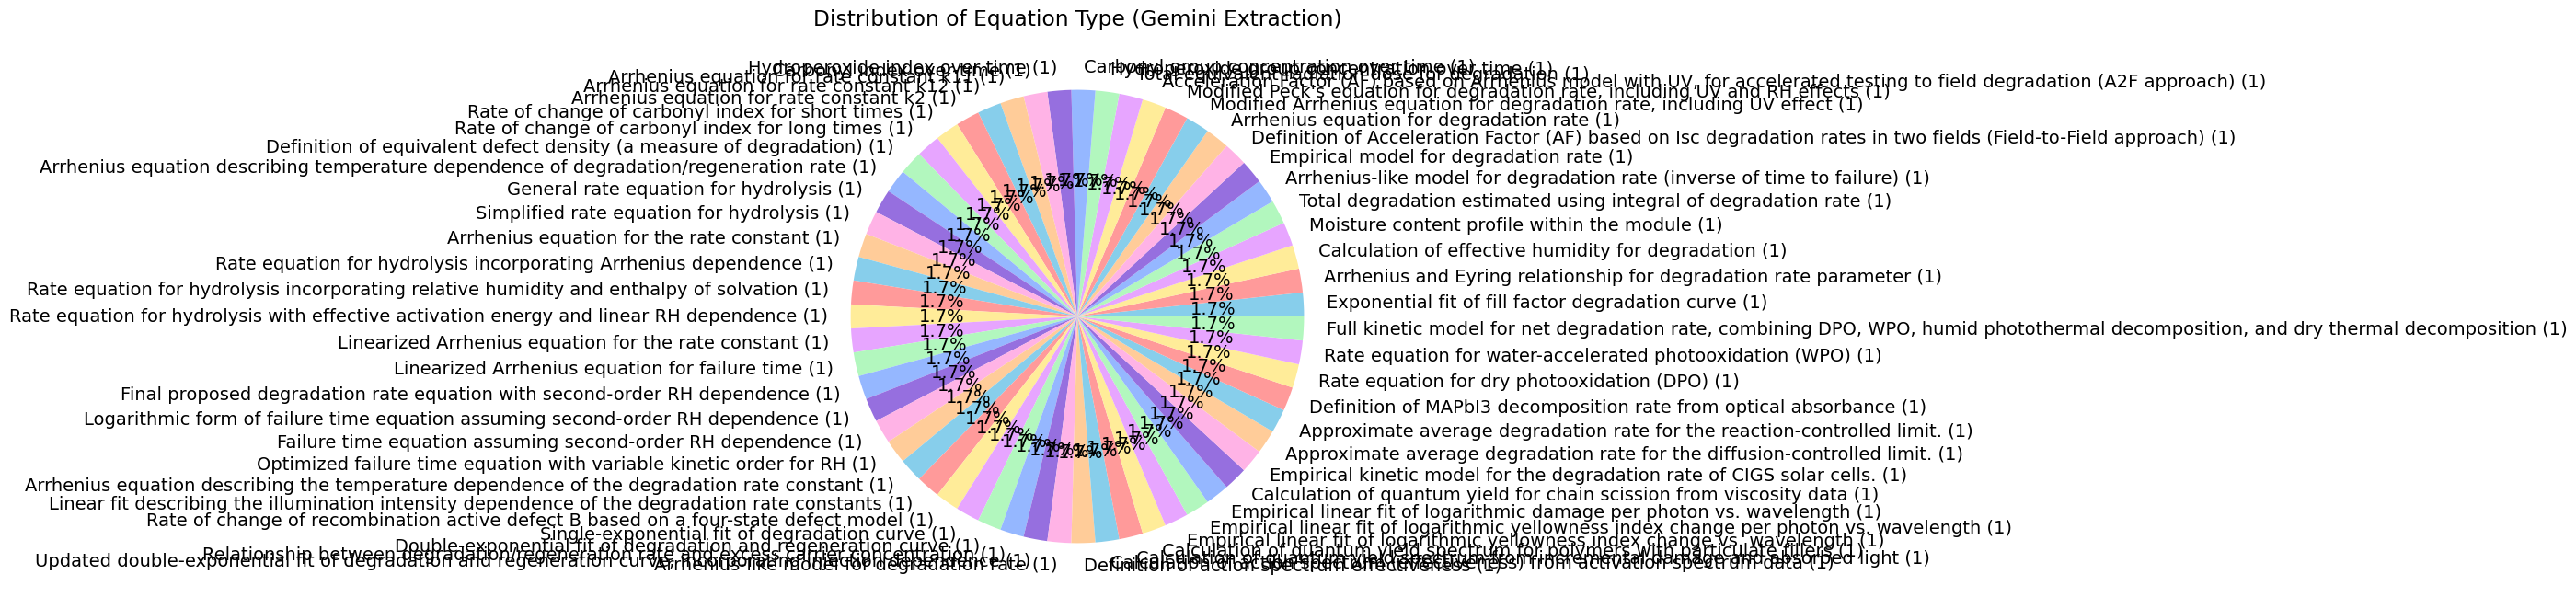

In [43]:
import os
import glob
import json
import matplotlib.pyplot as plt

# Collect all JSON files in the folder
json_folder = "json"
json_files = glob.glob(os.path.join(json_folder, "*.json"))

colors = ['#87CEEB', "#FF9A9A", "#FFEC99", "#E7A5FF", "#B2F7BE", "#95B7FF", "#966fdf", "#ffb3e6", "#ffcc99"]
equation_type_counts = {}

for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        # Handle both single dict and list of dicts
        if isinstance(data, dict):
            dicts = [data]
        else:
            dicts = data
        for entry in dicts:
            eq_type = entry.get("EquationType", "not reported")
            equation_type_counts[eq_type] = equation_type_counts.get(eq_type, 0) + 1

# Prepare data for pie chart
labels = []
sizes = []
for eq_type, count in equation_type_counts.items():
    labels.append(f"{eq_type} ({count})")
    sizes.append(count)

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors = colors, autopct=lambda pct: f"{pct:.1f}%")
plt.title("Distribution of Equation Type (Gemini Extraction)")
plt.show()

In [44]:
# question2 extracted 61 equations
# manual extraction had 27

In [45]:
# equation types and counts: 
# Vant_Hoff_TOW_Schwarzchild x1
# Arrhenius_BET4 x1
# Arrhenius_BET5 x1
# Arrhenius_BET6 x1
# Arrhenius_RH_Irradiance x4
# Arrhenius_tfail_RH x5
# Perovskite_1 x1
# FF_Arrhenius x1
# Arrhenius_Connector x1
# Arrhenius_Coffin_Manson_Peck x1
# Modified_arrhenius_G x1
#Arrhenius_G_DeltaT x1
# LeTID x6
# Activation Spectrum x1
# Arrhenius_Schwarzchild_340 x1

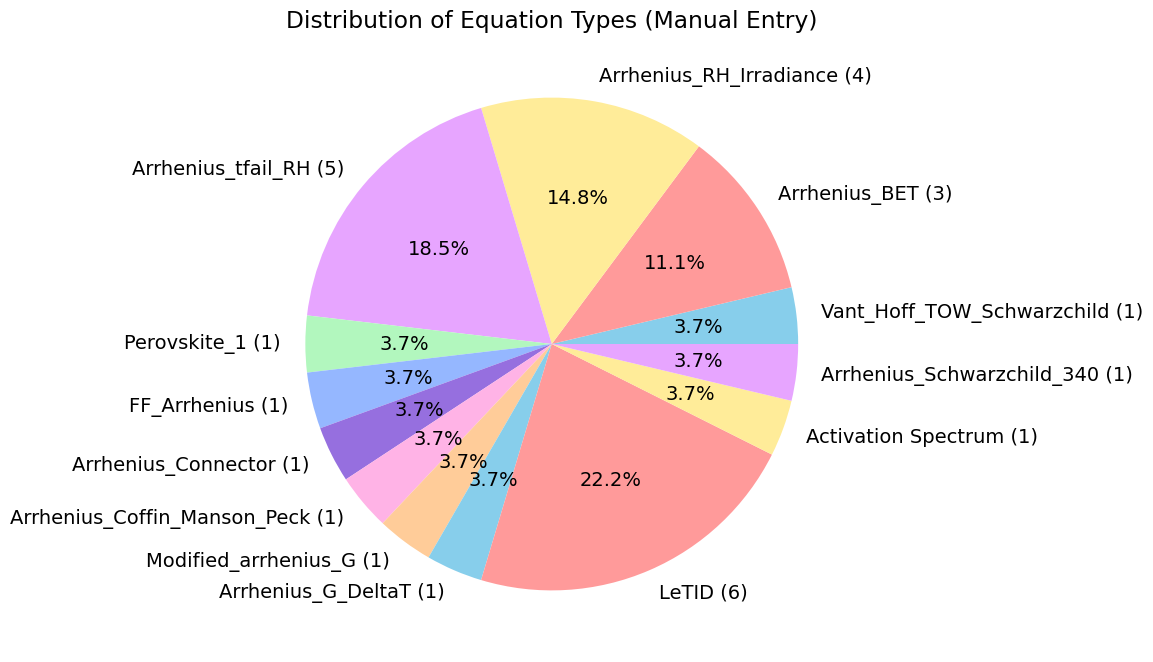

In [46]:
import matplotlib.pyplot as plt

# Text list of equation types and counts
equation_type_lines = [
    "Vant_Hoff_TOW_Schwarzchild x1",
    "Arrhenius_BET x3",
    "Arrhenius_RH_Irradiance x4",
    "Arrhenius_tfail_RH x5",
    "Perovskite_1 x1",
    "FF_Arrhenius x1",
    "Arrhenius_Connector x1",
    "Arrhenius_Coffin_Manson_Peck x1",
    "Modified_arrhenius_G x1",
    "Arrhenius_G_DeltaT x1",
    "LeTID x6",
    "Activation Spectrum x1",
    "Arrhenius_Schwarzchild_340 x1"
]

# Parse the lines to get labels and counts
labels = []
sizes = []
for line in equation_type_lines:
    if "x" in line:
        eq_type, count = line.rsplit("x", 1)
        labels.append(eq_type.strip())
        sizes.append(int(count.strip()))

# Use the colors variable already defined in the notebook
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=[f"{l} ({s})" for l, s in zip(labels, sizes)], colors=colors, autopct=lambda pct: f"{pct:.1f}%")
plt.rcParams.update({'font.size': 14})
plt.title("Distribution of Equation Types (Manual Entry)")
plt.show()